In [2]:
import numpy as np

from time import time

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

In [3]:
import rustworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
import sys
sys.path.append(r'.')  # may be needed if running notebook on a cloud service
from heisenberg_model import HeisenbergModel

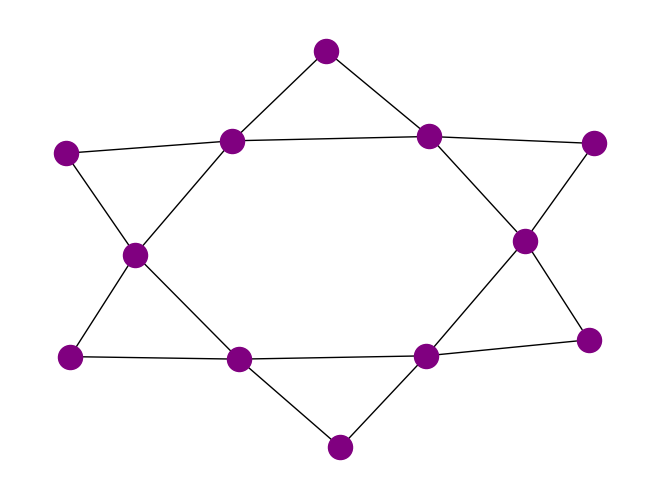

In [4]:
# Kagome unit cell
num_sites = 12
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 5, t),
    (5, 0, t),
    (0, 6, t),
    (1, 6, t),
    (1, 7, t),
    (2, 7, t),
    (2, 8, t),
    (3, 8, t),
    (3, 9, t),
    (4, 9, t),
    (4, 10, t),
    (5, 10, t),
    (5, 11, t),
    (0, 11, t),
]
# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice
kagome_unit_cell.draw(style={'node_color':'purple'})
# plt.savefig('kagome_unit_cell.png')
plt.show()

In [6]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

In [7]:
heis = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No singe site external field
)

# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham = 4 * log_mapper.map(heis.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect.
# There are 18 edges and 3 terms per edge (XX, YY, and ZZ),
# so there should be 54 equally weighted terms.
ham

PauliSumOp(SparsePauliOp(['ZIIIIIZIIIII', 'IZIIIIZIIIII', 'IZIIIIIZIIII', 'IIZIIIIZIIII', 'IIIIIIZZIIII', 'IIZIIIIIZIII', 'IIIZIIIIZIII', 'IIIIIIIZZIII', 'IIIZIIIIIZII', 'IIIIZIIIIZII', 'IIIIIIIIZZII', 'IIIIZIIIIIZI', 'IIIIIZIIIIZI', 'IIIIIIIIIZZI', 'ZIIIIIIIIIIZ', 'IIIIIZIIIIIZ', 'IIIIIIZIIIIZ', 'IIIIIIIIIIZZ', 'YIIIIIYIIIII', 'IYIIIIYIIIII', 'IYIIIIIYIIII', 'IIYIIIIYIIII', 'IIIIIIYYIIII', 'IIYIIIIIYIII', 'IIIYIIIIYIII', 'IIIIIIIYYIII', 'IIIYIIIIIYII', 'IIIIYIIIIYII', 'IIIIIIIIYYII', 'IIIIYIIIIIYI', 'IIIIIYIIIIYI', 'IIIIIIIIIYYI', 'YIIIIIIIIIIY', 'IIIIIYIIIIIY', 'IIIIIIYIIIIY', 'IIIIIIIIIIYY', 'XIIIIIXIIIII', 'IXIIIIXIIIII', 'IXIIIIIXIIII', 'IIXIIIIXIIII', 'IIIIIIXXIIII', 'IIXIIIIIXIII', 'IIIXIIIIXIII', 'IIIIIIIXXIII', 'IIIXIIIIIXII', 'IIIIXIIIIXII', 'IIIIIIIIXXII', 'IIIIXIIIIIXI', 'IIIIIXIIIIXI', 'IIIIIIIIIXXI', 'XIIIIIIIIIIX', 'IIIIIXIIIIIX', 'IIIIIIXIIIIX', 'IIIIIIIIIIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j

In [31]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)

# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[2], 4)

[-18.         -18.         -16.96132284]


In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider(instance='ibm-q/open/main')

In [10]:
sim = provider.get_backend('ibm_lagos')

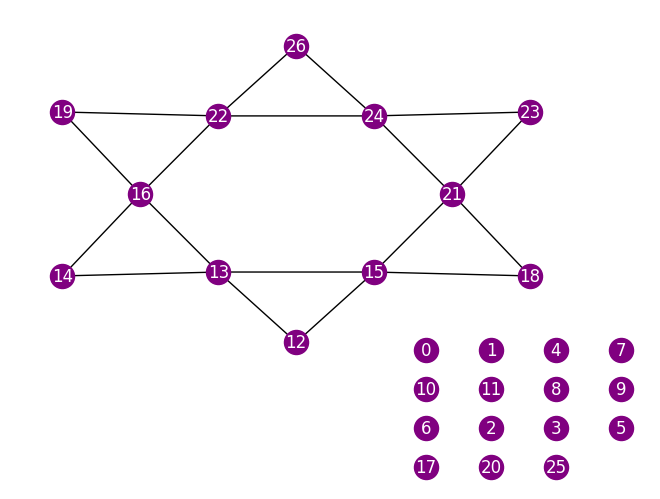

In [11]:
# Kagome unit cell
num_qubits = 27
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_25 = rx.PyGraph(multigraph=False)
graph_25.add_nodes_from(range(num_qubits))
edge_list = [
    (12,13, t),
    (13, 14, t),
    (14, 16, t),
    (16, 19, t),
    (19, 22, t),
    (22, 26, t),
    (26, 24, t),
    (24, 23, t),
    (23, 21, t),
    (21, 18, t),
    (18, 15, t),
    (15, 12, t),
    (15, 13, t),
    (13, 16, t),
    (16, 22, t),
    (22, 24, t),
    (24, 21, t),
    (21,15, t),
]
# Generate graph from the list of edges
graph_25.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_25 = Lattice(graph_25)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
# kagome_pos = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1], 
#               1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
#               13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
#               8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
kagome_pos={0:[1,-1], 1:[1.5,-1], 4:[2,-1], 7:[2.5,-1],
10:[1,-2], 11:[1.5,-2], 8:[2,-2], 9:[2.5,-2],
6:[1,-3], 2:[1.5,-3], 3:[2,-3], 5:[2.5,-3],
17:[1,-4], 20:[1.5,-4], 25:[2,-4], 
    
              12:[0,-0.8], 13:[-0.6,1], 15:[0.6,1], 21:[1.2,3], 
              24:[0.6,5], 22:[-0.6,5], 16:[-1.2,3], 14:[-1.8,0.9], 
              19:[-1.8,5.1], 26:[0,6.8], 18:[1.8,0.9], 23:[1.8,5.1]}



kagome_unit_cell_25.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()

In [12]:
# Build Hamiltonian from graph edges
heis_25 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_25,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_25 = 4 * log_mapper.map(heis_25.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
ham_25

PauliSumOp(SparsePauliOp(['ZIZIIIIIIIIIIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIII', 'IIZIZIIIIIIIIIIIIIIIIIIIIII', 'IIZIIZIIIIIIIIIIIIIIIIIIIII', 'IIIZIZIIIIIIIIIIIIIIIIIIIII', 'IIIIZIIZIIIIIIIIIIIIIIIIIII', 'IIIIIZIIZIIIIIIIIIIIIIIIIII', 'IIIIZIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIZIIZIIIIIIIIIIIIIIII', 'IIIIIZIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIZIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIZIZIIIIIIIIIIIIII', 'IIIIIIIIIIZIIZIIIIIIIIIIIII', 'IIIIIIIIIIIZIZIIIIIIIIIIIII', 'IIIIIIIIIIIIZZIIIIIIIIIIIII', 'IIIIIIIIIIIZIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIZZIIIIIIIIIIII', 'YIYIIIIIIIIIIIIIIIIIIIIIIII', 'IIYYIIIIIIIIIIIIIIIIIIIIIII', 'YIIIYIIIIIIIIIIIIIIIIIIIIII', 'IIYIYIIIIIIIIIIIIIIIIIIIIII', 'IIYIIYIIIIIIIIIIIIIIIIIIIII', 'IIIYIYIIIIIIIIIIIIIIIIIIIII', 'IIIIYIIYIIIIIIIIIIIIIIIIIII', 'IIIIIYIIYIIIIIIIIIIIIIIIIII', 'IIIIYIIIIIYIIIIIIIIIIIIIIII', 'IIIIIIIYIIYIIIIIIIIIIIIIIII', 'IIIIIYIIIIIYIIIIIIIIIIIIIII', 'IIIIIIIIYIIYIIIIIIIIIIIIIII', 'IIIIIIIIIIYIYIIIIIIIIIIIIII', 'IIIIIIIIIIYI

In [13]:
from qiskit.circuit.library import EfficientSU2
from qiskit import Aer, transpile

In [14]:
ansatz =EfficientSU2(12, entanglement='reverse_linear', reps=1, skip_final_rotation_layer=True).decompose()
ansatz.draw(fold=300) #fold=300

┌──────────┐┌───────────┐                                                       
 q_0: ─┤ Ry(θ[0]) ├┤ Rz(θ[12]) ├────────────────────────────────────────────────────■──
       ├──────────┤├───────────┤                                                  ┌─┴─┐
 q_1: ─┤ Ry(θ[1]) ├┤ Rz(θ[13]) ├───────────────────────────────────────────────■──┤ X ├
       ├──────────┤├───────────┤                                             ┌─┴─┐└───┘
 q_2: ─┤ Ry(θ[2]) ├┤ Rz(θ[14]) ├──────────────────────────────────────────■──┤ X ├─────
       ├──────────┤├───────────┤                                        ┌─┴─┐└───┘     
 q_3: ─┤ Ry(θ[3]) ├┤ Rz(θ[15]) ├─────────────────────────────────────■──┤ X ├──────────
       ├──────────┤├───────────┤                                   ┌─┴─┐└───┘          
 q_4: ─┤ Ry(θ[4]) ├┤ Rz(θ[16]) ├────────────────────────────────■──┤ X ├───────────────
       ├──────────┤├───────────┤                              ┌─┴─┐└───┘               
 q_5: ─┤ Ry(θ[5]) ├┤ Rz(θ[17]) ├───────────────────────────■──┤ X ├────────────────────
       ├──────────┤├───────────┤                         ┌─┴─┐└───┘                    
 q_6: ─┤ Ry(θ[6]) ├┤ Rz(θ[18]) ├──────────────────────■──┤ X ├─────────────────────────
       ├──────────┤├───────────┤                    ┌─┴─┐└───┘                         
 q_7: ─┤ Ry(θ[7]) ├┤ Rz(θ[19]) ├─────────────────■──┤ X ├──────────────────────────────
       ├──────────┤├───────────┤               ┌─┴─┐└───┘                              
 q_8: ─┤ Ry(θ[8]) ├┤ Rz(θ[20]) ├────────────■──┤ X ├───────────────────────────────────
       ├──────────┤├───────────┤          ┌─┴─┐└───┘                                   
 q_9: ─┤ Ry(θ[9]) ├┤ Rz(θ[21]) ├───────■──┤ X ├────────────────────────────────────────
      ┌┴──────────┤├───────────┤     ┌─┴─┐└───┘                                        
q_10: ┤ Ry(θ[10]) ├┤ Rz(θ[22]) ├──■──┤ X ├─────────────────────────────────────────────
      ├───────────┤├───────────┤┌─┴─┐└───┘                                             
q_11: ┤ Ry(θ[11]) ├┤ Rz(θ[23]) ├┤ X ├──────────────────────────────────────────────────
      └───────────┘└───────────┘└───┘

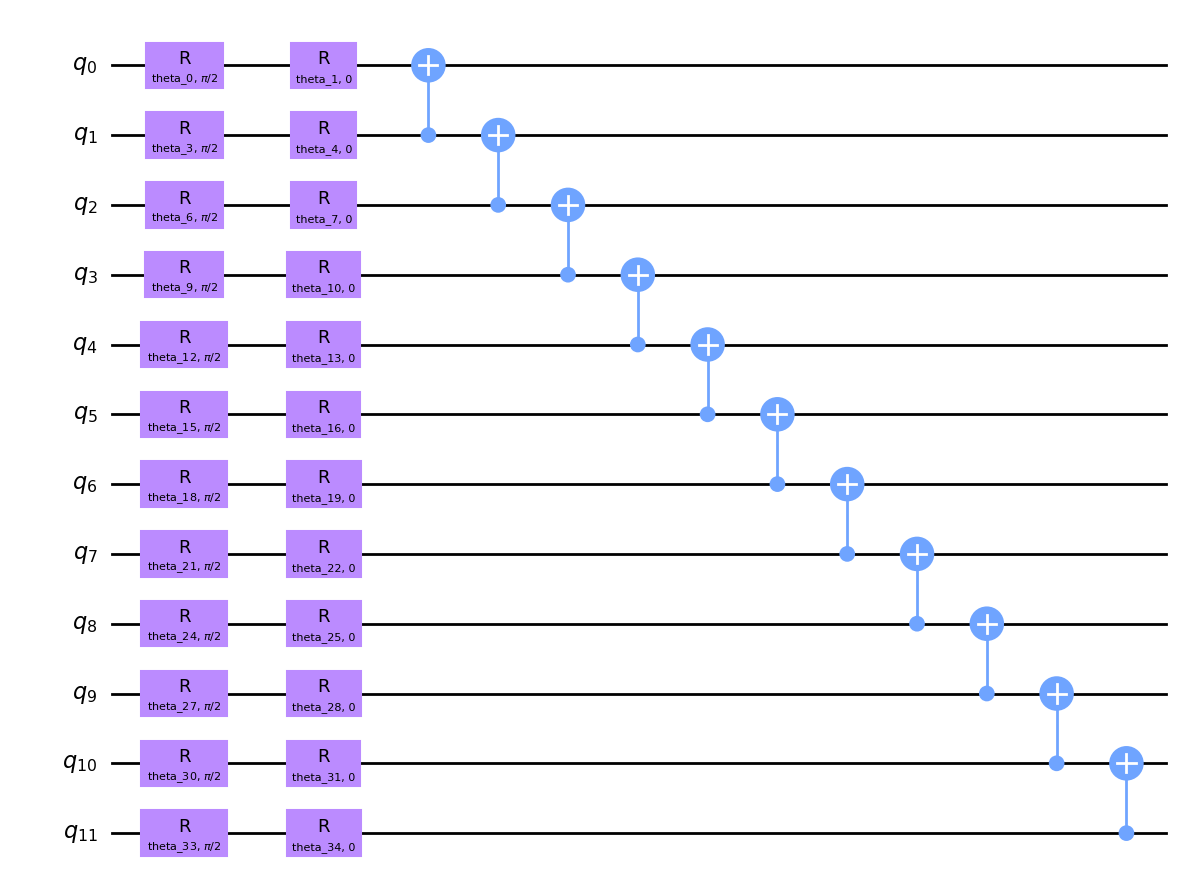

In [24]:
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt

def HEA_ansatz(qubits, depth, entanglement):
    circuit = QuantumCircuit(qubits)
    
    # Initialize parameters
    params = [Parameter(f'theta_{i}') for i in range(3*depth*qubits)]
    param_idx = 0
    
    # Apply alternating layers of single-qubit rotations and entangling gates
    for d in range(depth):
        for q in range(qubits):
            # Apply single-qubit rotations to every qubit in parallel
            circuit.ry(params[param_idx], q)
            circuit.rx(params[param_idx+1], q)
            #circuit.rz(params[param_idx+2], q)
            param_idx += 3
            
        # Apply entangling gates based on the chosen entanglement pattern
        for q in range(qubits):
            if entanglement == 'linear':
                if q < qubits-1:
                    circuit.cx(q, q+1)
            elif entanglement == 'reverse_linear':
                if q > 0:
                    circuit.cx(q, q-1)
            elif entanglement == 'circular':
                circuit.cx(q, (q+1) % qubits)
            elif entanglement == 'full':
                for k in range(q+1, qubits):
                    circuit.cx(q, k)
                    
    return circuit
ansatz = HEA_ansatz(12,1,'reverse_linear').decompose()
# Draw the circuit using matplotlib
fig, ax = plt.subplots(figsize=(15, 15)) 
circuit_drawer(ansatz, output='mpl', ax=ax)
ax.axis('off')
plt.show()

In [25]:
q_layout = [12,13,14,16,19,22,26,24,23,21,18,15] 
ansatz_opt = transpile(ansatz, backend=Aer.get_backend('aer_simulator_matrix_product_state'), initial_layout=q_layout)

print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
ansatz_opt.draw(fold=300)

number and type of gates in the cirucit: OrderedDict([('r', 24), ('cx', 11)])
number of parameters in the circuit: 24


ancilla_0 -> 0 ───────────────────────────────────────────────────────────────────────────────────────────
                                                                                                            
  ancilla_1 -> 1 ───────────────────────────────────────────────────────────────────────────────────────────
                                                                                                            
  ancilla_2 -> 2 ───────────────────────────────────────────────────────────────────────────────────────────
                                                                                                            
  ancilla_3 -> 3 ───────────────────────────────────────────────────────────────────────────────────────────
                                                                                                            
  ancilla_4 -> 4 ───────────────────────────────────────────────────────────────────────────────────────────
                                                                                                            
  ancilla_5 -> 5 ───────────────────────────────────────────────────────────────────────────────────────────
                                                                                                            
  ancilla_6 -> 6 ───────────────────────────────────────────────────────────────────────────────────────────
                                                                                                            
  ancilla_7 -> 7 ───────────────────────────────────────────────────────────────────────────────────────────
                                                                                                            
  ancilla_8 -> 8 ───────────────────────────────────────────────────────────────────────────────────────────
                                                                                                            
  ancilla_9 -> 9 ───────────────────────────────────────────────────────────────────────────────────────────
                                                                                                            
ancilla_10 -> 10 ───────────────────────────────────────────────────────────────────────────────────────────
                                                                                                            
ancilla_11 -> 11 ───────────────────────────────────────────────────────────────────────────────────────────
                  ┌────────────────┐ ┌──────────────┐┌───┐                                                  
       q_0 -> 12 ─┤ R(theta_0,π/2) ├─┤ R(theta_1,0) ├┤ X ├──────────────────────────────────────────────────
                  ├────────────────┤ ├──────────────┤└─┬─┘┌───┐                                             
       q_1 -> 13 ─┤ R(theta_3,π/2) ├─┤ R(theta_4,0) ├──■──┤ X ├─────────────────────────────────────────────
                  ├────────────────┤ ├──────────────┤     └─┬─┘┌───┐                                        
       q_2 -> 14 ─┤ R(theta_6,π/2) ├─┤ R(theta_7,0) ├───────■──┤ X ├────────────────────────────────────────
                 ┌┴────────────────┤┌┴──────────────┤          └─┬─┘                                        
      q_11 -> 15 ┤ R(theta_33,π/2) ├┤ R(theta_34,0) ├────────────┼───────────────────────────────────────■──
                 └┬────────────────┤├───────────────┤            │  ┌───┐                                │  
       q_3 -> 16 ─┤ R(theta_9,π/2) ├┤ R(theta_10,0) ├────────────■──┤ X ├────────────────────────────────┼──
                  └────────────────┘└───────────────┘               └─┬─┘                                │  
ancilla_12 -> 17 ─────────────────────────────────────────────────────┼──────────────────────────────────┼──
                 ┌─────────────────┐┌───────────────┐                 │                                ┌─┴─┐
      q_10 -> 18 ┤ R(theta_30,π/2) ├┤ R(theta_31,0) ├─────────────────┼───────

In [26]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=150)

In [27]:
from qiskit.algorithms import VQE
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit import QuantumCircuit

In [28]:
intermediate_info = []
mn=[]
sd=[]
eva=[]
para=[]
def callback(eval_count, param_set, mean, std):
    intermediate_info.append({'eval_count': eval_count, 'params': param_set, 'mean': mean, 'std': std})
    mn.append(mean)
    sd.append(std)
    eva.append(eval_count)
    para.append(param_set)

In [29]:
spsa = SPSA(150)


#simulator

qi = Aer.get_backend('aer_simulator_matrix_product_state')
vqe_circuit = VQE(ansatz_opt, quantum_instance=qi, optimizer=spsa,callback=callback)

vqe_circuit

In [30]:
start = time()
result = vqe_circuit.compute_minimum_eigenvalue(ham_25)
end = time()

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 300,
    'eigenstate': {   '000000000011001000000000000': 0.03125,
                      '000001011000100000000000000': 0.03125,
                      '000001011010001000000000000': 0.03125,
                      '000100010001101000000000000': 0.06987712429686843,
                      '000100010001110000000000000': 0.11267347735824966,
                      '000100010011001000000000000': 0.0625,
                      '000100010011010000000000000': 0.08267972847076846,
                      '000100011000101000000000000': 0.09375,
                      '000100011000110000000000000': 0.09375,
                      '000100011010001000000000000': 0.09375,
                      '000100011010010000000000000': 0.08838834764831845,
                      '000101011001101000000000000': 0.03125,
                      '000110000001101000000000000': 0.10364452469860624,
                      '000110000001110000000000000': 0.1432054904

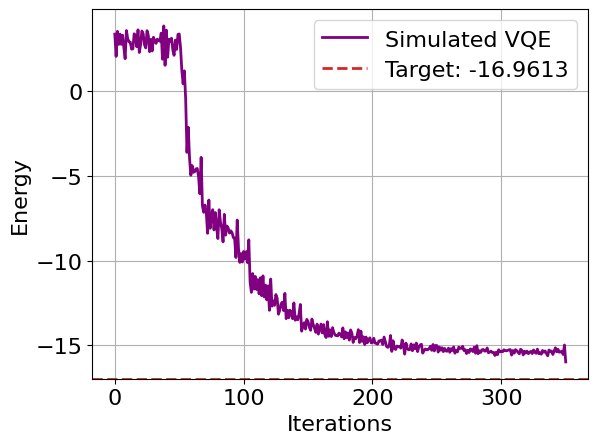

In [32]:
plt.plot(mn, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [33]:
def rel_err(target, measured):
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -16.9613000000
Computed ground state energy: -15.9726562500+0.0000000000j
Relative error: 0.05828821
